# Useful Imports

In [1]:
import pickle
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer, CLIPProcessor, CLIPModel
from PIL import Image

import sys
import os
sys.path.append(os.path.abspath(".."))
from src.modeling.model import ClipCaptionModel

c:\Users\moote\.conda\envs\image_captioning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_path = "sofia_1.jpg"
model_path = "../trained_models/best_model_onlyProjector_20250727_021320.pkl"

# Models

In [28]:
# GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

# CLIP
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [29]:
# Caption Model
with open(model_path, "rb") as f:
    checkpoint = pickle.load(f)
print(checkpoint.keys())
model = ClipCaptionModel(clip_emb_dim=512, visual_tokens_length=checkpoint["gpt2_config"].visual_tokens_length, gpt2_model=gpt2_model)
model.load_state_dict(checkpoint["caption_model_state_dict"])
model = model.to(device)
model.eval()

dict_keys(['caption_model_state_dict', 'clip_config', 'gpt2_config', 'training_config', 'train_loss', 'validation_loss', 'validation_bert_precision', 'validation_bert_recall', 'validation_bert_f1_score'])


ClipCaptionModel(
  (gpt): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=768, out_featur

# Load Image and Generate Caption

In [30]:
image = Image.open(image_path).convert("RGB")
image = image.resize((checkpoint["clip_config"].image_size[0], checkpoint["clip_config"].image_size[1]))
inputs = clip_processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    clip_embed = clip_model.get_image_features(**inputs)

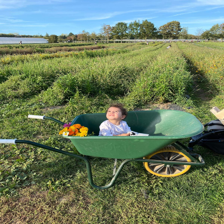

In [31]:
image

In [32]:
with torch.no_grad():
    generated_ids = model.generate(
        clip_embed=clip_embed,
        max_length=30,
        num_beams=5,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id,
    )

    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    print("Generated caption:", caption)

Generated caption: A small child sitting on the back of a pickup truck.
